In [1]:
from os.path import exists

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_friedman1
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam, SGD, RMSprop

Підключаємо гугл диск, на якому буде збережено згенерований датасет, моделі та історія їх навчання

In [2]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
DATA_DIR = "/content/drive/My Drive/ai/" # Директорія, де  буде збережено згенерований датасет, моделі та історія їх навчання
DATA_DIR = "./data/"

## Генерація/завантаження датасету

In [3]:
load = True # Згенерувати нові дані чи завантажити існуючі

if load:
    X = np.load(DATA_DIR + "X.npy")
    y = np.load(DATA_DIR + "y.npy")
else:
    X, y = make_friedman1(n_samples=150_000, n_features=10)

    np.save(DATA_DIR + "X", X)
    np.save(DATA_DIR + "y", y)

In [4]:
print("X:", X, sep="\n")
print("y:", y, sep="\n")
print(f"Min x {np.min(X)}, max x {np.max(X)}")
print(f"Min y {np.min(y)}, max y {np.max(y)}")

X:
[[0.6276258  0.86214464 0.89263484 ... 0.97469684 0.57813874 0.41094127]
 [0.27744292 0.46392083 0.05204787 ... 0.3622791  0.61838196 0.92663297]
 [0.92108686 0.02191539 0.48270836 ... 0.32016088 0.93796346 0.87034597]
 ...
 [0.87513633 0.81199328 0.46184908 ... 0.13573194 0.9331889  0.19938294]
 [0.21967225 0.07684679 0.27604684 ... 0.95627656 0.59918419 0.51917151]
 [0.62162028 0.77329336 0.1563185  ... 0.69137964 0.78353178 0.94320617]]
y:
[23.8923759  17.06315594  6.4487802  ... 16.67398449 14.78644001
 22.18221849]
Min x 1.9105694463172895e-06, max x 0.9999993994276258
Min y 0.3174856842783556, max y 29.42166359491788


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(f"Train size: {X_train.shape}, test size: {X_test.shape}")

Train size: (105000, 10), test size: (45000, 10)


## Лінійна регресія

In [10]:
LR = LinearRegression()
LR_history = LR.fit(X, y)
print("Train score:", LR.score(X_train, y_train))
print("Test score:", LR.score(X_test, y_test))

Train score: 0.7501667219047836
Test score: 0.7541855654575358


In [ ]:
print("C:", LR.coef_)
print("Intercept:", LR.intercept_)

C: [ 6.68702710e+00  6.73319562e+00  1.69922141e-02  1.00124721e+01
  4.99876872e+00 -2.45658253e-03  2.08330419e-03 -2.46441671e-02
  2.52495806e-02 -4.45759173e-03]
Intercept: 0.18387248003077694


In [ ]:
y_pred = LR.predict(X_test)
LR_df = pd.DataFrame({'True': y_test, 'Predicted': y_pred})
LR_df

,True,Predicted
0,21.798699,22.389363
1,6.931616,8.585501
2,23.685924,23.203960
3,13.739441,15.157112
4,16.017701,16.079444
...,...,...
44995,13.739994,12.984316
44996,8.287319,9.371831
44997,15.989932,16.092712
44998,15.518113,15.005784


In [11]:
def calc_metrics(epoch, y_train, y_train_pred, y_test, y_test_pred):
    # print("y_train:", y_train.size, y_train)
    # print("y_train_pred:", y_train_pred.size, y_train_pred)

    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
    mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    return pd.DataFrame(
        {
            "R2 train": r2_train, "R2 test": r2_test,
            "MSE train": mse_train, "MSE test": mse_test,
            "MAPE train": mape_train, "MAPE test": mape_test,
            "MAE train": mae_train, "MAE test": mae_test
        }, index=[epoch])


In [12]:
baseline = calc_metrics("LR", y_train, LR.predict(X_train), y_test, LR.predict(X_test))

Функція знаходження втрат для тестового датасету

In [ ]:
def test_less(model, criterion, test_dataset):
    dataloader = DataLoader(test_dataset)
    num_batches = len(dataloader)

    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += criterion(pred, y).item()

    return test_loss / num_batches


In [ ]:
def train(model, train_dataset, test_dataset, criterion, optimizer, epochs):
    dataloader = DataLoader(train_dataset)
    num_batches = len(dataloader)
    history = pd.DataFrame(columns=["Loss train", "Loss test"])

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}:")

        epoch_loss = 0.0
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(dataloader):
            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            epoch_loss += loss.item()
            if i % 5000 == 4999:
                print(f"[{epoch + 1}/{epochs}, {i + 1}/{len(train_dataset)}] loss: {running_loss / 5000:.3f}")
                running_loss = 0.0

        x_train, y_train = train_dataset.tensors
        x_test, y_test = test_dataset.tensors

        y_train_pred = model(x_train)
        y_test_pred = model(x_test)

        history = pd.concat([history, calc_metrics(epoch + 1, y_train.cpu().detach().numpy(),
                                                   y_train_pred.cpu().detach().numpy(), y_test.cpu().detach().numpy(),
                                                   y_test_pred.cpu().detach().numpy())])

        epoch_loss /= num_batches

        print(f"[{epoch + 1}/{epochs}] mean epoch loss: {epoch_loss:.3f}")

        history.at[epoch + 1, "Loss train"] = epoch_loss
        history.at[epoch + 1, "Loss test"] = test_less(model, criterion, test_dataset)

    return history



In [ ]:
x_train_tensor = Tensor(X_train).to("cuda")
y_train_tensor = Tensor(y_train).to("cuda")
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

x_test_tensor = Tensor(X_test).to("cuda")
y_test_tensor = Tensor(y_test).to("cuda")
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

In [5]:
class DNN1(nn.Module):
    def __init__(self):
        super(DNN1, self).__init__()
        layers = [nn.Linear(10, 30), nn.ReLU(), nn.Linear(30, 30), nn.ReLU(), nn.Linear(30, 1)]

        self.linear_relu_stack = nn.Sequential(*layers)

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


class DNN2(nn.Module):
    def __init__(self):
        super(DNN2, self).__init__()
        layers = [nn.Linear(10, 30), nn.ReLU()]

        for i in range(5):
            layers += [nn.Linear(30, 30), nn.ReLU()]

        layers += [nn.Linear(30, 1)]

        self.linear_relu_stack = nn.Sequential(*layers)

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


class DNN3(nn.Module):
    def __init__(self):
        super(DNN3, self).__init__()
        layers = [nn.Linear(10, 30), nn.ReLU()]

        for i in range(25):
            layers += [nn.Linear(30, 30)]

        layers += [nn.ReLU(), nn.Linear(30, 1)]

        self.linear_relu_stack = nn.Sequential(*layers)

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
def train_and_save(epochs, train_dataset, test_dataset, model_class, optimizer_class, learning_rate):
    name = f"{model_class.__name__}-{optimizer_class.__name__}-{learning_rate}-{epochs}-epoch"
    print(f"Train {name} model")
    model = model_class().to("cuda")

    optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    history = train(model, train_dataset, test_dataset, nn.MSELoss(), optimizer, epochs)

    torch.save(model.state_dict(), f"{DATA_DIR}{name}.pth")
    print(f"Saved PyTorch Model State to {DATA_DIR}{name}.pth")

    history.to_csv(f"{DATA_DIR}{name}-history.csv")
    print(f"Saved PyTorch Model history to {DATA_DIR}{name}-history.csv")

    return name, history, model


## Навчання DNN

In [ ]:
epochs = 5

result_histories = {}
result_models = {}

for dnn in [DNN3]:  #[DNN1, DNN2, DNN3]:
    for optimizer in [SGD, RMSprop, Adam]:
        for lr in [0.1, 0.01, 0.001]:
          try:
            name, history, model = train_and_save(epochs, train_dataset, test_dataset, dnn, optimizer, lr)

            result_histories[name] = history
            result_models[name] = model
          except Exception as e:
            print(e)

Train DNN3-SGD-0.1-5-epoch model
Epoch 1:


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1/5, 5000/105000] loss: nan
[1/5, 10000/105000] loss: nan
[1/5, 15000/105000] loss: nan
[1/5, 20000/105000] loss: nan
[1/5, 25000/105000] loss: nan
[1/5, 30000/105000] loss: nan
[1/5, 35000/105000] loss: nan
[1/5, 40000/105000] loss: nan
[1/5, 45000/105000] loss: nan
[1/5, 50000/105000] loss: nan
[1/5, 55000/105000] loss: nan
[1/5, 60000/105000] loss: nan
[1/5, 65000/105000] loss: nan
[1/5, 70000/105000] loss: nan
[1/5, 75000/105000] loss: nan
[1/5, 80000/105000] loss: nan
[1/5, 85000/105000] loss: nan
[1/5, 90000/105000] loss: nan
[1/5, 95000/105000] loss: nan
[1/5, 100000/105000] loss: nan
[1/5, 105000/105000] loss: nan
Input contains NaN, infinity or a value too large for dtype('float32').
Train DNN3-SGD-0.01-5-epoch model
Epoch 1:


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1/5, 5000/105000] loss: nan
[1/5, 10000/105000] loss: nan
[1/5, 15000/105000] loss: nan
[1/5, 20000/105000] loss: nan
[1/5, 25000/105000] loss: nan
[1/5, 30000/105000] loss: nan
[1/5, 35000/105000] loss: nan
[1/5, 40000/105000] loss: nan
[1/5, 45000/105000] loss: nan
[1/5, 50000/105000] loss: nan
[1/5, 55000/105000] loss: nan
[1/5, 60000/105000] loss: nan
[1/5, 65000/105000] loss: nan
[1/5, 70000/105000] loss: nan
[1/5, 75000/105000] loss: nan
[1/5, 80000/105000] loss: nan
[1/5, 85000/105000] loss: nan
[1/5, 90000/105000] loss: nan
[1/5, 95000/105000] loss: nan
[1/5, 100000/105000] loss: nan
[1/5, 105000/105000] loss: nan
Input contains NaN, infinity or a value too large for dtype('float32').
Train DNN3-SGD-0.001-5-epoch model
Epoch 1:


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1/5, 5000/105000] loss: 68.900
[1/5, 10000/105000] loss: 61.685
[1/5, 15000/105000] loss: 62.036
[1/5, 20000/105000] loss: 61.129
[1/5, 25000/105000] loss: 60.063
[1/5, 30000/105000] loss: 62.525
[1/5, 35000/105000] loss: 61.217
[1/5, 40000/105000] loss: 62.330
[1/5, 45000/105000] loss: 60.439
[1/5, 50000/105000] loss: 62.476
[1/5, 55000/105000] loss: 60.572
[1/5, 60000/105000] loss: 62.524
[1/5, 65000/105000] loss: 60.929
[1/5, 70000/105000] loss: 59.997
[1/5, 75000/105000] loss: 59.919
[1/5, 80000/105000] loss: 59.792
[1/5, 85000/105000] loss: 61.009
[1/5, 90000/105000] loss: 60.343
[1/5, 95000/105000] loss: 60.208
[1/5, 100000/105000] loss: 62.320
[1/5, 105000/105000] loss: 59.961
[1/5] mean epoch loss: 24.579


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2:
[2/5, 5000/105000] loss: 60.346
[2/5, 10000/105000] loss: 60.622
[2/5, 15000/105000] loss: 61.364
[2/5, 20000/105000] loss: 60.514
[2/5, 25000/105000] loss: 59.498
[2/5, 30000/105000] loss: 61.954
[2/5, 35000/105000] loss: 60.636
[2/5, 40000/105000] loss: 61.727
[2/5, 45000/105000] loss: 59.904
[2/5, 50000/105000] loss: 61.766
[2/5, 55000/105000] loss: 60.031
[2/5, 60000/105000] loss: 61.933
[2/5, 65000/105000] loss: 60.311
[2/5, 70000/105000] loss: 59.460
[2/5, 75000/105000] loss: 59.400
[2/5, 80000/105000] loss: 59.201
[2/5, 85000/105000] loss: 60.386
[2/5, 90000/105000] loss: 59.872
[2/5, 95000/105000] loss: 59.720
[2/5, 100000/105000] loss: 61.727
[2/5, 105000/105000] loss: 59.403
[2/5] mean epoch loss: 24.186


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 3:
[3/5, 5000/105000] loss: 59.812
[3/5, 10000/105000] loss: 60.071
[3/5, 15000/105000] loss: 60.718
[3/5, 20000/105000] loss: 59.996
[3/5, 25000/105000] loss: 58.969
[3/5, 30000/105000] loss: 61.483
[3/5, 35000/105000] loss: 60.134
[3/5, 40000/105000] loss: 61.222
[3/5, 45000/105000] loss: 59.517
[3/5, 50000/105000] loss: 61.095
[3/5, 55000/105000] loss: 59.663
[3/5, 60000/105000] loss: 61.426
[3/5, 65000/105000] loss: 59.797
[3/5, 70000/105000] loss: 59.024
[3/5, 75000/105000] loss: 58.975
[3/5, 80000/105000] loss: 58.697
[3/5, 85000/105000] loss: 59.912
[3/5, 90000/105000] loss: 59.542
[3/5, 95000/105000] loss: 59.326
[3/5, 100000/105000] loss: 61.444
[3/5, 105000/105000] loss: 59.145
[3/5] mean epoch loss: 23.999


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 4:
[4/5, 5000/105000] loss: 59.597
[4/5, 10000/105000] loss: 59.770
[4/5, 15000/105000] loss: 60.400
[4/5, 20000/105000] loss: 59.806
[4/5, 25000/105000] loss: 58.789
[4/5, 30000/105000] loss: 61.343
[4/5, 35000/105000] loss: 59.961
[4/5, 40000/105000] loss: 61.104
[4/5, 45000/105000] loss: 59.477
[4/5, 50000/105000] loss: 60.955
[4/5, 55000/105000] loss: 59.658
[4/5, 60000/105000] loss: 61.356
[4/5, 65000/105000] loss: 59.729
[4/5, 70000/105000] loss: 58.973
[4/5, 75000/105000] loss: 58.945
[4/5, 80000/105000] loss: 58.671
[4/5, 85000/105000] loss: 59.906
[4/5, 90000/105000] loss: 59.529
[4/5, 95000/105000] loss: 59.318
[4/5, 100000/105000] loss: 61.440
[4/5, 105000/105000] loss: 59.143
[4/5] mean epoch loss: 23.959


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 5:
[5/5, 5000/105000] loss: 59.596
[5/5, 10000/105000] loss: 59.769
[5/5, 15000/105000] loss: 60.399
[5/5, 20000/105000] loss: 59.805
[5/5, 25000/105000] loss: 58.789
[5/5, 30000/105000] loss: 61.342
[5/5, 35000/105000] loss: 59.961
[5/5, 40000/105000] loss: 61.104
[5/5, 45000/105000] loss: 59.477
[5/5, 50000/105000] loss: 60.955
[5/5, 55000/105000] loss: 59.658
[5/5, 60000/105000] loss: 61.356
[5/5, 65000/105000] loss: 59.729
[5/5, 70000/105000] loss: 58.973
[5/5, 75000/105000] loss: 58.945
[5/5, 80000/105000] loss: 58.671
[5/5, 85000/105000] loss: 59.906
[5/5, 90000/105000] loss: 59.529
[5/5, 95000/105000] loss: 59.318
[5/5, 100000/105000] loss: 61.440
[5/5, 105000/105000] loss: 59.143
[5/5] mean epoch loss: 23.959


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Saved PyTorch Model State to /content/drive/My Drive/ai/DNN3-SGD-0.001-5-epoch.pth
Saved PyTorch Model history to /content/drive/My Drive/ai/DNN3-SGD-0.001-5-epoch-history.csv
Train DNN3-RMSprop-0.1-5-epoch model
Epoch 1:
[1/5, 5000/105000] loss: 2490858496880554094362624.000
[1/5, 10000/105000] loss: 2181581548155832553701376.000
[1/5, 15000/105000] loss: 1930920667965603627139072.000
[1/5, 20000/105000] loss: 1661907806636828820242432.000
[1/5, 25000/105000] loss: 1442465100990135261986816.000
[1/5, 30000/105000] loss: 1210561508430948759240704.000
[1/5, 35000/105000] loss: 1029626914706235693465600.000
[1/5, 40000/105000] loss: 841595016377591287250944.000
[1/5, 45000/105000] loss: 681385583989571654254592.000
[1/5, 50000/105000] loss: 1810820363717864708898816.000
[1/5, 55000/105000] loss: 1836048497331122993102848.000
[1/5, 60000/105000] loss: 1624902881341100926173184.000
[1/5, 65000/105000] loss: 1450331147299088595156992.000
[1/5, 70000/105000] loss: 1252315907487592708308992.0

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2:
[2/5, 5000/105000] loss: 364772668748230765314048.000
[2/5, 10000/105000] loss: 296909117273569186807808.000
[2/5, 15000/105000] loss: 258766114113227302371328.000
[2/5, 20000/105000] loss: 210933153753642284613632.000
[2/5, 25000/105000] loss: 181758636169715492323328.000
[2/5, 30000/105000] loss: 144910712503487631982592.000
[2/5, 35000/105000] loss: 127298380515916816318464.000
[2/5, 40000/105000] loss: 102135362903641168019456.000
[2/5, 45000/105000] loss: 87512519630496655736832.000
[2/5, 50000/105000] loss: 73466504646719734546432.000
[2/5, 55000/105000] loss: 61087907931042720251904.000
[2/5, 60000/105000] loss: 50637873349240803033088.000
[2/5, 65000/105000] loss: 46331878973022016634880.000
[2/5, 70000/105000] loss: 33905555230134389178368.000
[2/5, 75000/105000] loss: 30181596987351491411968.000
[2/5, 80000/105000] loss: 28168003590018629107712.000
[2/5, 85000/105000] loss: 22832085616308728627200.000
[2/5, 90000/105000] loss: 20864003534834894897152.000
[2/5, 95000/

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 3:
[3/5, 5000/105000] loss: 11684903443168881541120.000
[3/5, 10000/105000] loss: 11159756298226493292544.000
[3/5, 15000/105000] loss: 9701497871117425049600.000
[3/5, 20000/105000] loss: 8856939249920760610816.000
[3/5, 25000/105000] loss: 8711289160942361772032.000
[3/5, 30000/105000] loss: 6722864484649828089856.000
[3/5, 35000/105000] loss: 6940903388900257431552.000
[3/5, 40000/105000] loss: 5875618306827231428608.000
[3/5, 45000/105000] loss: 5445452976704460947456.000
[3/5, 50000/105000] loss: 4404884844847246082048.000
[3/5, 55000/105000] loss: 4086729391265322893312.000
[3/5, 60000/105000] loss: 3319067985472729382912.000
[3/5, 65000/105000] loss: 4566469533747189383168.000
[3/5, 70000/105000] loss: 2726877767502490763264.000
[3/5, 75000/105000] loss: 2980076186089846996992.000
[3/5, 80000/105000] loss: 3485279884452689346560.000
[3/5, 85000/105000] loss: 2877054071647904464896.000
[3/5, 90000/105000] loss: 2740373573775291056128.000
[3/5, 95000/105000] loss: 2277430430

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 4:
[4/5, 5000/105000] loss: 2001848343422339645440.000
[4/5, 10000/105000] loss: 2618808362358801432576.000
[4/5, 15000/105000] loss: 2033559844264712863744.000
[4/5, 20000/105000] loss: 2146778386884576935936.000
[4/5, 25000/105000] loss: 2401670620364195495936.000
[4/5, 30000/105000] loss: 1886845937602915729408.000
[4/5, 35000/105000] loss: 2064889616265086763008.000
[4/5, 40000/105000] loss: 1945085499641624264704.000
[4/5, 45000/105000] loss: 1918417679712635322368.000
[4/5, 50000/105000] loss: 1548092148027910520832.000
[4/5, 55000/105000] loss: 1646272600932139139072.000
[4/5, 60000/105000] loss: 1335596296709613813760.000
[4/5, 65000/105000] loss: 1988493249544823242752.000
[4/5, 70000/105000] loss: 1360839906238751047680.000
[4/5, 75000/105000] loss: 1443278511888128016384.000
[4/5, 80000/105000] loss: 1819873749216935542784.000
[4/5, 85000/105000] loss: 1569083230905341575168.000
[4/5, 90000/105000] loss: 1523833773562405847040.000
[4/5, 95000/105000] loss: 135767609066

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 5:
[5/5, 5000/105000] loss: 1281988979586069168128.000
[5/5, 10000/105000] loss: 1823081204803229188096.000
[5/5, 15000/105000] loss: 1379946835812392108032.000
[5/5, 20000/105000] loss: 1524635536977729945600.000
[5/5, 25000/105000] loss: 1718505851333534285824.000
[5/5, 30000/105000] loss: 1428852808280826445824.000
[5/5, 35000/105000] loss: 1533466985872785145856.000
[5/5, 40000/105000] loss: 1511089161220074766336.000
[5/5, 45000/105000] loss: 1523023277346175320064.000
[5/5, 50000/105000] loss: 1283087002889960554496.000
[5/5, 55000/105000] loss: 1403651195921368088576.000
[5/5, 60000/105000] loss: 1162048428316490203136.000
[5/5, 65000/105000] loss: 1637661392530256166912.000
[5/5, 70000/105000] loss: 1232863019935002001408.000
[5/5, 75000/105000] loss: 1265796037134022868992.000
[5/5, 80000/105000] loss: 1593738995844281794560.000
[5/5, 85000/105000] loss: 1405597555932577398784.000
[5/5, 90000/105000] loss: 1361334019050477977600.000
[5/5, 95000/105000] loss: 125873578406

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Saved PyTorch Model State to /content/drive/My Drive/ai/DNN3-RMSprop-0.1-5-epoch.pth
Saved PyTorch Model history to /content/drive/My Drive/ai/DNN3-RMSprop-0.1-5-epoch-history.csv
Train DNN3-RMSprop-0.01-5-epoch model
Epoch 1:
[1/5, 5000/105000] loss: 30604480270301224.000
[1/5, 10000/105000] loss: 119495563124571392.000
[1/5, 15000/105000] loss: 6684834695900446480714956800.000
[1/5, 20000/105000] loss: 6976249349455278335997247488.000
[1/5, 25000/105000] loss: 6976234775937164198335741952.000
[1/5, 30000/105000] loss: 6975849073850771415750410240.000
[1/5, 35000/105000] loss: 6975784322384871504186703872.000
[1/5, 40000/105000] loss: 6975751774802054039201644544.000
[1/5, 45000/105000] loss: 6976128522396152227516383232.000
[1/5, 50000/105000] loss: 6975859907402204747787141120.000
[1/5, 55000/105000] loss: 6975804363075206994095767552.000
[1/5, 60000/105000] loss: 6976610379980704068315119616.000
[1/5, 65000/105000] loss: 6976115422551528861469769728.000
[1/5, 70000/105000] loss: 69

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2:
[2/5, 5000/105000] loss: 6975036480016929031131758592.000
[2/5, 10000/105000] loss: 6975296349188150447384297472.000
[2/5, 15000/105000] loss: 6975559889409015683982819328.000
[2/5, 20000/105000] loss: 6975390568073329169896833024.000
[2/5, 25000/105000] loss: 6975379258595898516251344896.000
[2/5, 30000/105000] loss: 6974996613651506209212071936.000
[2/5, 35000/105000] loss: 6974937418344922178574614528.000
[2/5, 40000/105000] loss: 6974907965092741839868395520.000
[2/5, 45000/105000] loss: 6975289289988128188271689728.000
[2/5, 50000/105000] loss: 6975026386991589679742058496.000
[2/5, 55000/105000] loss: 6974972305565184316948873216.000
[2/5, 60000/105000] loss: 6975783035835152501932294144.000
[2/5, 65000/105000] loss: 6975286889550214977567064064.000
[2/5, 70000/105000] loss: 6974410824011790401075675136.000
[2/5, 75000/105000] loss: 6974362643329879248532930560.000
[2/5, 80000/105000] loss: 6974471085392607860370702336.000
[2/5, 85000/105000] loss: 6974621127962276474482

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 3:
[3/5, 5000/105000] loss: 6974208791728919691372003328.000
[3/5, 10000/105000] loss: 6974467058837311978815356928.000
[3/5, 15000/105000] loss: 6974731915565408830867111936.000
[3/5, 20000/105000] loss: 6974562840973370809225576448.000


## Завантаження моделей та історій

Функція для завантаження моделі і історії з диску

In [6]:
def load_model_and_history(model_class, optimizer_class, learning_rate, epochs):
    name = f"{model_class.__name__}-{optimizer_class.__name__}-{learning_rate}-{epochs}-epoch"

    if exists(f"{DATA_DIR}{name}.pth"):
        model = model_class()
        model.load_state_dict(torch.load(f"{DATA_DIR}{name}.pth"))
        model.eval()
        print(f"Load PyTorch Model State from {name}.pth")
    else:
        model = None
        print(f"Can't load Model State from {name}.pth, file not exists!")

    if exists(f"{DATA_DIR}{name}-history.csv"):
        history = pd.read_csv(f"{DATA_DIR}{name}-history.csv", index_col="Unnamed: 0")
        print(f"Load PyTorch Model history from {DATA_DIR}{name}-history.csv")
    else:
        history = None
        print(f"Can't load Model history from {name}.pth, file not exists!")

    return name, history, model

In [ ]:
name, history, model = load_model_and_history(DNN2, Adam, 0.01, 5)

Load PyTorch Model State from DNN2-Adam-0.01-5-epoch.pth
Load PyTorch Model history from /content/drive/My Drive/ai/DNN2-Adam-0.01-5-epoch-history.csv


In [ ]:
history

,Loss train,Loss test,R2 train,R2 test,MSE train,MSE test,MAPE train,MAPE test,MAE train,MAE test
1,2.112286,2.852360,0.881493,0.880282,2.844388,2.852360,0.100433,0.100362,1.438286,1.443341
2,0.963045,2.208461,0.908182,0.907308,2.203801,2.208461,0.091654,0.091055,1.227623,1.229701
3,0.912053,2.931271,0.878389,0.876970,2.918887,2.931271,0.098922,0.098939,1.428313,1.434474
4,0.839505,0.686924,0.971158,0.971169,0.692259,0.686924,0.058213,0.057528,0.676173,0.674956
5,0.787974,1.174182,0.951026,0.950718,1.175476,1.174182,0.065484,0.065156,0.879301,0.880835


In [13]:
result_histories = {}
result_models = {}
total_acc = baseline.copy()

epochs = 5
for dnn in [DNN1, DNN2, DNN3]:
    for optimizer in [SGD, RMSprop, Adam]:
        for lr in [0.1, 0.01, 0.001]:
            name, history, model = load_model_and_history(dnn, optimizer, lr, epochs)
            if history is not None and model is not None:
                result_histories[name] = history
                result_models[name] = model

                result = history.loc[epochs - 1]
                result.name = name
                total_acc = total_acc.append(result)


Load PyTorch Model State from DNN1-SGD-0.1-5-epoch.pth
Load PyTorch Model history from ./data/DNN1-SGD-0.1-5-epoch-history.csv


C:\Users\Danylo\AppData\Local\Temp\ipykernel_33180\2127119678.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_acc = total_acc.append(result)
C:\Users\Danylo\AppData\Local\Temp\ipykernel_33180\2127119678.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_acc = total_acc.append(result)
C:\Users\Danylo\AppData\Local\Temp\ipykernel_33180\2127119678.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_acc = total_acc.append(result)
C:\Users\Danylo\AppData\Local\Temp\ipykernel_33180\2127119678.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_acc = total_acc.append(result)
C:\Users\Danylo\AppData\Local\Temp\i

Load PyTorch Model State from DNN1-SGD-0.01-5-epoch.pth
Load PyTorch Model history from ./data/DNN1-SGD-0.01-5-epoch-history.csv
Load PyTorch Model State from DNN1-SGD-0.001-5-epoch.pth
Load PyTorch Model history from ./data/DNN1-SGD-0.001-5-epoch-history.csv
Load PyTorch Model State from DNN1-RMSprop-0.1-5-epoch.pth
Load PyTorch Model history from ./data/DNN1-RMSprop-0.1-5-epoch-history.csv
Load PyTorch Model State from DNN1-RMSprop-0.01-5-epoch.pth
Load PyTorch Model history from ./data/DNN1-RMSprop-0.01-5-epoch-history.csv
Load PyTorch Model State from DNN1-RMSprop-0.001-5-epoch.pth
Load PyTorch Model history from ./data/DNN1-RMSprop-0.001-5-epoch-history.csv
Load PyTorch Model State from DNN1-Adam-0.1-5-epoch.pth
Load PyTorch Model history from ./data/DNN1-Adam-0.1-5-epoch-history.csv
Load PyTorch Model State from DNN1-Adam-0.01-5-epoch.pth
Load PyTorch Model history from ./data/DNN1-Adam-0.01-5-epoch-history.csv
Load PyTorch Model State from DNN1-Adam-0.001-5-epoch.pth
Load PyTorc

C:\Users\Danylo\AppData\Local\Temp\ipykernel_33180\2127119678.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_acc = total_acc.append(result)
C:\Users\Danylo\AppData\Local\Temp\ipykernel_33180\2127119678.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_acc = total_acc.append(result)
C:\Users\Danylo\AppData\Local\Temp\ipykernel_33180\2127119678.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_acc = total_acc.append(result)
C:\Users\Danylo\AppData\Local\Temp\ipykernel_33180\2127119678.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_acc = total_acc.append(result)
C:\Users\Danylo\AppData\Local\Temp\i

Load PyTorch Model State from DNN2-SGD-0.001-5-epoch.pth
Load PyTorch Model history from ./data/DNN2-SGD-0.001-5-epoch-history.csv
Load PyTorch Model State from DNN2-RMSprop-0.1-5-epoch.pth
Load PyTorch Model history from ./data/DNN2-RMSprop-0.1-5-epoch-history.csv
Load PyTorch Model State from DNN2-RMSprop-0.01-5-epoch.pth
Load PyTorch Model history from ./data/DNN2-RMSprop-0.01-5-epoch-history.csv
Load PyTorch Model State from DNN2-RMSprop-0.001-5-epoch.pth
Load PyTorch Model history from ./data/DNN2-RMSprop-0.001-5-epoch-history.csv
Load PyTorch Model State from DNN2-Adam-0.1-5-epoch.pth
Load PyTorch Model history from ./data/DNN2-Adam-0.1-5-epoch-history.csv
Load PyTorch Model State from DNN2-Adam-0.01-5-epoch.pth
Load PyTorch Model history from ./data/DNN2-Adam-0.01-5-epoch-history.csv
Load PyTorch Model State from DNN2-Adam-0.001-5-epoch.pth
Load PyTorch Model history from ./data/DNN2-Adam-0.001-5-epoch-history.csv
Can't load Model State from DNN3-SGD-0.1-5-epoch.pth, file not ex

C:\Users\Danylo\AppData\Local\Temp\ipykernel_33180\2127119678.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_acc = total_acc.append(result)
C:\Users\Danylo\AppData\Local\Temp\ipykernel_33180\2127119678.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_acc = total_acc.append(result)
C:\Users\Danylo\AppData\Local\Temp\ipykernel_33180\2127119678.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_acc = total_acc.append(result)


# Аналіз

Таблиця коефіцієнтів детермінації(R2), Mean Square Error, Mean Absolute Percentage Error, Mean Absolute Error для лінійної регресії(LR) і повнозв'язних нейронних мереж (5 епох для кожної)

In [14]:
pd.options.display.float_format = lambda x: f"{x:.2f}" if abs(x) < 1000  else f"{x:.2E}"
total_acc.sort_values("R2 train", ascending=False)

,R2 train,R2 test,MSE train,MSE test,MAPE train,MAPE test,MAE train,MAE test,Loss test,Loss train
DNN1-SGD-0.001-5-epoch,1.00,1.00,0.02,0.02,0.01,0.01,0.11,0.11,0.02,0.03
DNN1-Adam-0.001-5-epoch,1.00,1.00,0.03,0.03,0.01,0.01,0.13,0.13,0.03,0.07
DNN1-RMSprop-0.001-5-epoch,1.00,1.00,0.04,0.04,0.01,0.01,0.14,0.14,0.04,0.08
DNN2-Adam-0.001-5-epoch,1.00,1.00,0.05,0.05,0.02,0.01,0.18,0.18,0.05,0.08
DNN2-RMSprop-0.001-5-epoch,1.00,1.00,0.08,0.07,0.02,0.02,0.20,0.20,0.07,0.09
DNN2-SGD-0.001-5-epoch,1.00,1.00,0.08,0.08,0.01,0.01,0.20,0.20,0.08,0.04
DNN1-Adam-0.01-5-epoch,0.98,0.98,0.43,0.43,0.04,0.04,0.51,0.51,0.43,0.29
DNN1-RMSprop-0.01-5-epoch,0.98,0.98,0.56,0.56,0.05,0.05,0.62,0.61,0.56,0.52
DNN2-Adam-0.01-5-epoch,0.97,0.97,0.69,0.69,0.06,0.06,0.68,0.67,0.69,0.84
DNN2-RMSprop-0.01-5-epoch,0.94,0.94,1.40,1.39,0.08,0.07,0.94,0.94,1.39,1.08


## Висновки
Бачимо що моделі
DNN1-SGD-0.1-5-epoch,
DNN1-SGD-0.01-5-epoch,
DNN3-SGD-0.001-5-epoch,
DNN2-Adam-0.1-5-epoch,
DNN2-RMSprop-0.1-5-epoch,
DNN2-SGD-0.01-5-epoch,
DNN2-SGD-0.1-5-epoch,
DNN3-RMSprop-0.1-5-epoch
мають нереалістичне значення R2 навіть для навчальних наборів, напевно це зумовлено некоректними комбінаціями оптимізатора і learning_rate.

In [26]:
acc_filtered = total_acc.sort_values("R2 train", ascending=False).head(13)
acc_filtered

,R2 train,R2 test,MSE train,MSE test,MAPE train,MAPE test,MAE train,MAE test,Loss test,Loss train
DNN1-SGD-0.001-5-epoch,1.00,1.00,0.02,0.02,0.01,0.01,0.11,0.11,0.02,0.03
DNN1-Adam-0.001-5-epoch,1.00,1.00,0.03,0.03,0.01,0.01,0.13,0.13,0.03,0.07
DNN1-RMSprop-0.001-5-epoch,1.00,1.00,0.04,0.04,0.01,0.01,0.14,0.14,0.04,0.08
DNN2-Adam-0.001-5-epoch,1.00,1.00,0.05,0.05,0.02,0.01,0.18,0.18,0.05,0.08
DNN2-RMSprop-0.001-5-epoch,1.00,1.00,0.08,0.07,0.02,0.02,0.20,0.20,0.07,0.09
DNN2-SGD-0.001-5-epoch,1.00,1.00,0.08,0.08,0.01,0.01,0.20,0.20,0.08,0.04
DNN1-Adam-0.01-5-epoch,0.98,0.98,0.43,0.43,0.04,0.04,0.51,0.51,0.43,0.29
DNN1-RMSprop-0.01-5-epoch,0.98,0.98,0.56,0.56,0.05,0.05,0.62,0.61,0.56,0.52
DNN2-Adam-0.01-5-epoch,0.97,0.97,0.69,0.69,0.06,0.06,0.68,0.67,0.69,0.84
DNN2-RMSprop-0.01-5-epoch,0.94,0.94,1.40,1.39,0.08,0.07,0.94,0.94,1.39,1.08


Найкращі результати демонструє нейронна мережа із 1 прихованим шаром і оптимізатором SGD чи Adam і lr=0.001, за ним слідує оптимізатор RMSprop. Дещо гіршу точність дає мережа із 5 прихованими шарами. Ще меншу точність дають моделі DNN1 і DNN2 із lr=0.01, проте все ще вища за лінійну регресію. Моделі із lr=0.1 дають набагато більші помилки.

In [39]:
def plot_learning_curves(name, history, baseline):
    plt.subplot(121)

    plt.plot(history["R2 train"], label="train")
    plt.plot(history["R2 test"], label="test")

    if baseline is not None:
        plt.axhline(baseline["R2 train"][0], label="baseline train", linestyle="--", c="tab:blue")
        plt.axhline(baseline["R2 test"][0], label="baseline test", linestyle="--", c="tab:orange")

    plt.title(f"{name}\naccuracy (R2)")
    plt.ylabel("R2")
    plt.xlabel("epoch")
    plt.legend(loc="upper left")
    plt.xlim(0, len(history))

    plt.subplot(122)
    plt.plot(history["MSE train"], label="train")
    plt.plot(history["MSE test"], label="test")

    if baseline is not None:
        plt.axhline(baseline["MSE train"][0], label="baseline train", linestyle="--", c="tab:blue")
        plt.axhline(baseline["MSE test"][0], label="baseline test", linestyle="--", c="tab:orange")

    plt.title(f"{name}\nloss (MSE)")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(loc="upper left")
    plt.xlim(0, len(history))
    plt.ylim(0)
    plt.tight_layout()
    plt.show()


## Learning curves

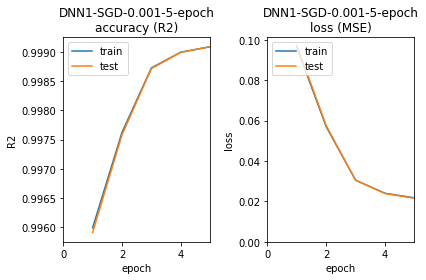

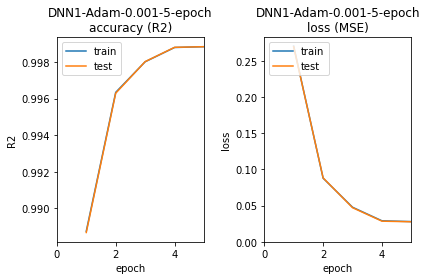

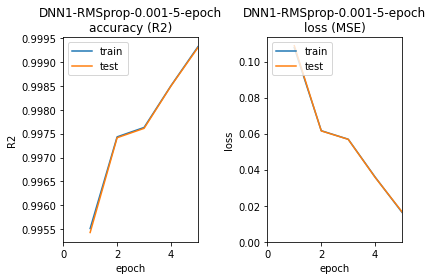

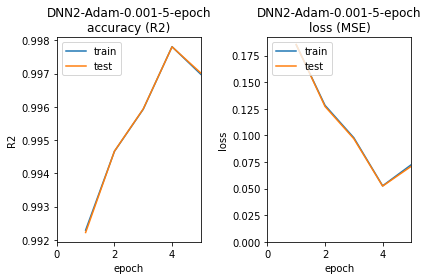

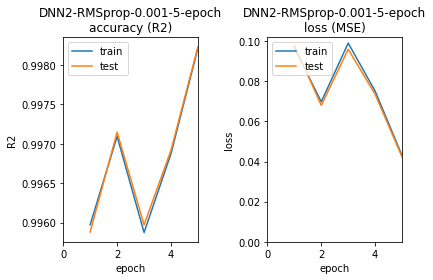

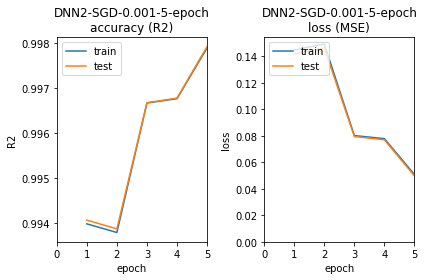

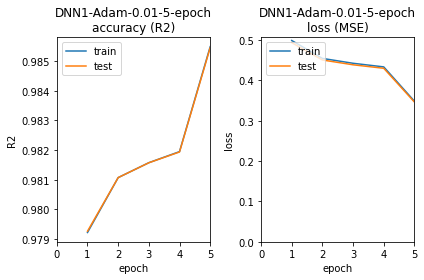

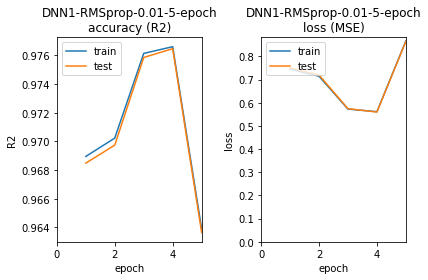

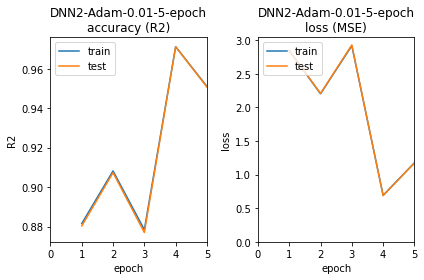

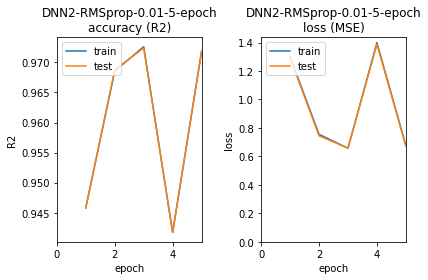

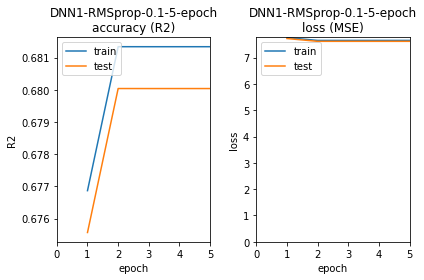

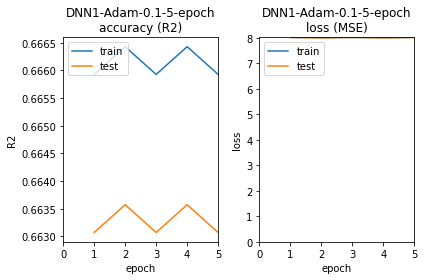

In [41]:
for name in acc_filtered.index:
    if name == "LR":
      continue

    plot_learning_curves(name, result_histories[name], None)

## Криві навчання для 3 найкращих комбінацій

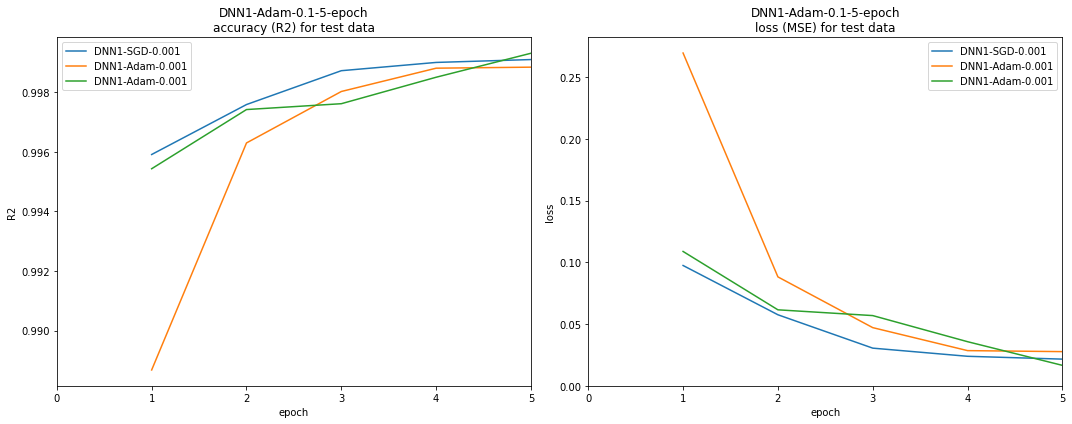

In [49]:
plt.rcParams["figure.figsize"] = (15, 6)

plt.subplot(121)

plt.plot(result_histories["DNN1-SGD-0.001-5-epoch"]["R2 test"], label="DNN1-SGD-0.001")

plt.plot(result_histories["DNN1-Adam-0.001-5-epoch"]["R2 test"], label="DNN1-Adam-0.001")

plt.plot(result_histories["DNN1-RMSprop-0.001-5-epoch"]["R2 test"], label="DNN1-Adam-0.001")
plt.xlim(0, len(result_histories["DNN1-RMSprop-0.001-5-epoch"]["R2 test"]))


plt.title(f"{name}\naccuracy (R2) for test data")
plt.ylabel("R2")
plt.xlabel("epoch")
plt.legend()

plt.subplot(122)
plt.plot(result_histories["DNN1-SGD-0.001-5-epoch"]["MSE test"], label="DNN1-SGD-0.001")

plt.plot(result_histories["DNN1-Adam-0.001-5-epoch"]["MSE test"], label="DNN1-Adam-0.001")

plt.plot(result_histories["DNN1-RMSprop-0.001-5-epoch"]["MSE test"], label="DNN1-Adam-0.001")

plt.xlim(0, len(result_histories["DNN1-RMSprop-0.001-5-epoch"]["R2 test"]))
plt.ylim(0)

plt.title(f"{name}\nloss (MSE) for test data")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.tight_layout()
plt.show()
